In [4]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_original_contratos = pd.read_csv("src/data/df_original_contratos_adiados.csv")
df_original_contratos = df_original_contratos.loc[:, ~df_original_contratos.columns.str.contains('^Unnamed')] 

df_original = pd.read_csv("src/data/df_original_dias_adiados.csv")
df_original = df_original.loc[:, ~df_original.columns.str.contains('^Unnamed')] 

#2.6s


Resumo por Tipo de Contrato:
                 contracts  concluded_rate  selection_rate  avg_adiamentos  \
tipo                                                                        
Ajudante             1423           48.63           49.26            1.97   
Coleta/Entrega       4128           59.84           60.05            1.78   
Diária               5845           66.62           66.72            1.69   

                avg_cand  avg_hours  
tipo                                 
Ajudante            1.72      33.30  
Coleta/Entrega      1.50      32.95  
Diária              2.28      35.71  

Taxa de Conclusão por Faixa de Candidaturas:
           contracts  concluded_rate
Cand Cat                           
0              1629            42.9
1–2            6506            64.9
3–5            2372            66.1
>5              889            63.7

Taxa de Conclusão por Faixa de Horas Médias:
            contracts  concluded_rate
Hours Cat                           
≤24h     

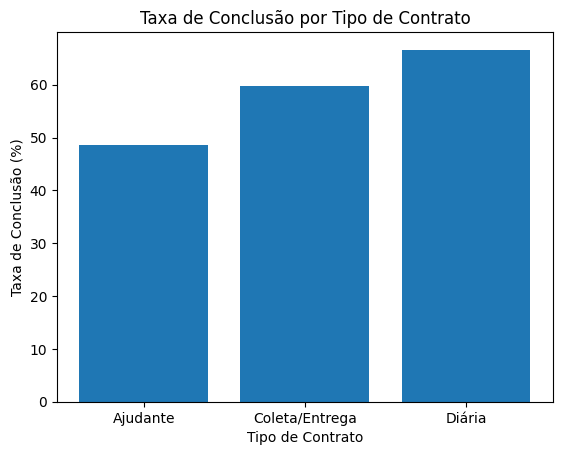

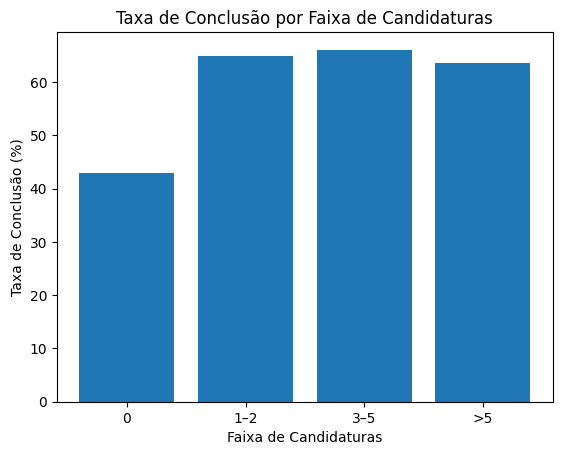

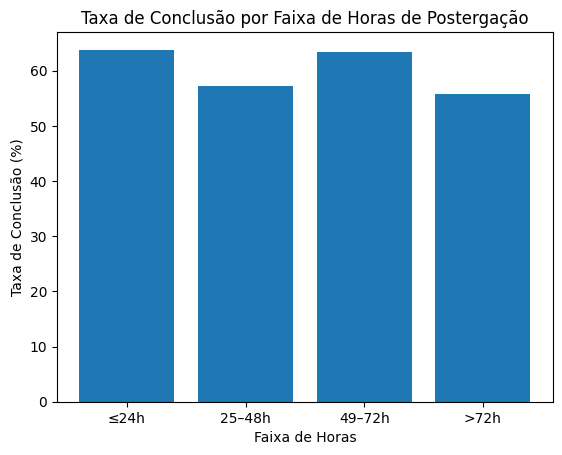

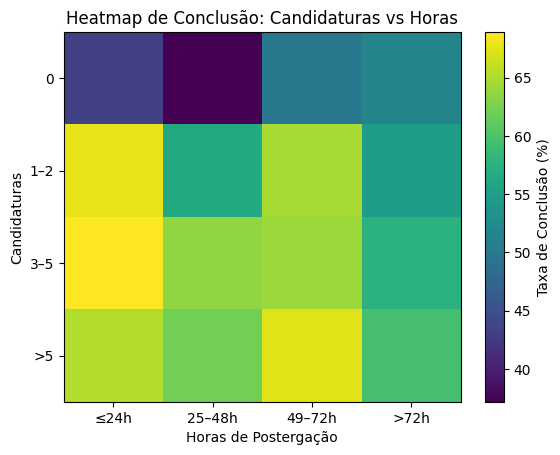

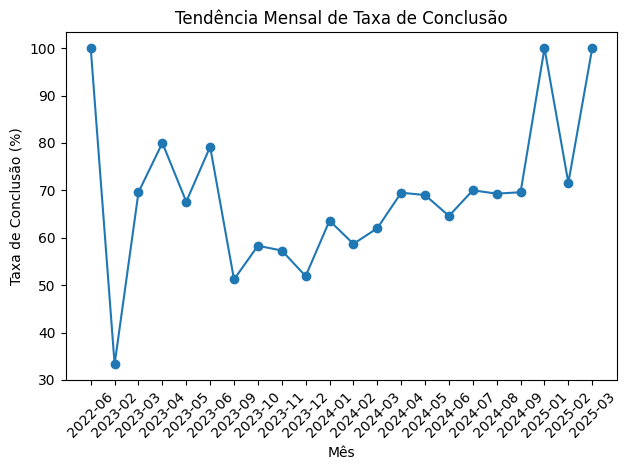

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carregar dados
df = pd.read_csv('src/data/contratos_adidados.csv', parse_dates=['created_at'])

# 2. Agregar por contrato
agg = df.groupby('freight_id').agg(
    tipo               = ('tipo', 'first'),
    total_adiamentos   = ('id_adiamento', 'count'),
    max_candidaturas   = ('qt_candidaturas_antes_adiamento', 'max'),
    avg_candidaturas   = ('qt_candidaturas_antes_adiamento', 'mean'),
    any_selection      = ('driver_id', lambda x: x.notna().any()),
    avg_hours          = ('horas_adicionadas', 'mean'),
    total_hours        = ('horas_adicionadas', 'sum'),
    concluded          = ('concluido', lambda x: (x == 'Sim').any()),
    first_date         = ('created_at', 'min')
).reset_index()

# 3. Criar categorias
def cat_cand(x):
    if x == 0:      return '0'
    elif x <= 2:    return '1–2'
    elif x <= 5:    return '3–5'
    else:           return '>5'

def cat_hours(x):
    if x <= 24:     return '≤24h'
    elif x <= 48:   return '25–48h'
    elif x <= 72:   return '49–72h'
    else:           return '>72h'

agg['Cand Cat']  = agg['max_candidaturas'].apply(cat_cand)
agg['Hours Cat'] = agg['avg_hours'].apply(cat_hours)
agg['Month']     = agg['first_date'].dt.to_period('M').astype(str)

# 4. Tabelas de resumo
# 4.1 Resumo por tipo de contrato
summary_tipo = agg.groupby('tipo').agg(
    contracts       = ('freight_id', 'count'),
    concluded_rate  = ('concluded', lambda x: x.mean() * 100),
    selection_rate  = ('any_selection', lambda x: x.mean() * 100),
    avg_adiamentos  = ('total_adiamentos', 'mean'),
    avg_cand        = ('avg_candidaturas', 'mean'),
    avg_hours       = ('avg_hours', 'mean')
).round(2)

# 4.2 Taxa de conclusão por faixa de candidaturas
order_cand = ['0','1–2','3–5','>5']
summary_cand = agg.groupby('Cand Cat').agg(
    contracts      = ('freight_id', 'count'),
    concluded_rate = ('concluded', lambda x: x.mean() * 100)
).reindex(order_cand).round(1)

# 4.3 Taxa de conclusão por faixa de horas médias
order_hours = ['≤24h','25–48h','49–72h','>72h']
summary_hours = agg.groupby('Hours Cat').agg(
    contracts      = ('freight_id', 'count'),
    concluded_rate = ('concluded', lambda x: x.mean() * 100)
).reindex(order_hours).round(1)

# 4.4 Cruzamento candidaturas vs. horas
cross = agg.groupby(['Cand Cat','Hours Cat']).agg(
    contracts      = ('freight_id', 'count'),
    concluded_rate = ('concluded', lambda x: x.mean() * 100)
).reset_index().round(1)

# 4.5 Tendência mensal
monthly = agg.groupby('Month').agg(
    contracts      = ('freight_id', 'count'),
    concluded_rate = ('concluded', lambda x: x.mean() * 100)
).reset_index().round(1)

# Exibir tabelas
print("\nResumo por Tipo de Contrato:\n", summary_tipo)
print("\nTaxa de Conclusão por Faixa de Candidaturas:\n", summary_cand)
print("\nTaxa de Conclusão por Faixa de Horas Médias:\n", summary_hours)
print("\nCandidaturas vs. Horas (Taxa de Conclusão):\n", cross)
print("\nTendência Mensal de Taxa de Conclusão:\n", monthly)

# 5. Visualizações
# 5.1 Taxa de conclusão por tipo de contrato
plt.figure()
plt.bar(summary_tipo.index, summary_tipo['concluded_rate'])
plt.title('Taxa de Conclusão por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Taxa de Conclusão (%)')
plt.show()

# 5.2 Taxa de conclusão por faixa de candidaturas
plt.figure()
plt.bar(summary_cand.index, summary_cand['concluded_rate'])
plt.title('Taxa de Conclusão por Faixa de Candidaturas')
plt.xlabel('Faixa de Candidaturas')
plt.ylabel('Taxa de Conclusão (%)')
plt.show()

# 5.3 Taxa de conclusão por faixa de horas de postergação
plt.figure()
plt.bar(summary_hours.index, summary_hours['concluded_rate'])
plt.title('Taxa de Conclusão por Faixa de Horas de Postergação')
plt.xlabel('Faixa de Horas')
plt.ylabel('Taxa de Conclusão (%)')
plt.show()

# 5.4 Heatmap de conclusão (Candidaturas vs Horas)
pivot = cross.pivot(index='Cand Cat', columns='Hours Cat', values='concluded_rate') \
             .reindex(index=order_cand, columns=order_hours)
plt.figure()
plt.imshow(pivot, aspect='auto')
plt.title('Heatmap de Conclusão: Candidaturas vs Horas')
plt.xlabel('Horas de Postergação')
plt.ylabel('Candidaturas')
plt.xticks(range(len(order_hours)), order_hours)
plt.yticks(range(len(order_cand)), order_cand)
plt.colorbar(label='Taxa de Conclusão (%)')
plt.show()

# 5.5 Tendência mensal de taxa de conclusão
plt.figure()
plt.plot(monthly['Month'], monthly['concluded_rate'], marker='o')
plt.title('Tendência Mensal de Taxa de Conclusão')
plt.xlabel('Mês')
plt.ylabel('Taxa de Conclusão (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# CONTRATOS

In [2]:
df_original_contratos = df_original_contratos.dropna()
df_original_contratos

,freight_id,tipo,horas_adiadas_total,concluido
0,119332,Ajudante,24.0,Não
1,119336,Ajudante,96.0,Não
2,119343,Diária,24.0,Sim
3,119350,Diária,24.0,Sim
4,119362,Coleta/Entrega,24.0,Sim
...,...,...,...,...
7135,154383,Coleta/Entrega,48.0,Sim
7136,154432,Diária,24.0,Sim
7137,154433,Coleta/Entrega,24.0,Sim
7138,154434,Coleta/Entrega,48.0,Não


Distribuição da quantidade de contratos concluídos:
                Concluídos (%)  Não Concluídos(%)  Total Contratos Analisados
tipo                                                                         
Ajudante                    61                 39                        1551
Coleta/Entrega              72                 28                        1951
Diária                      75                 25                        3638


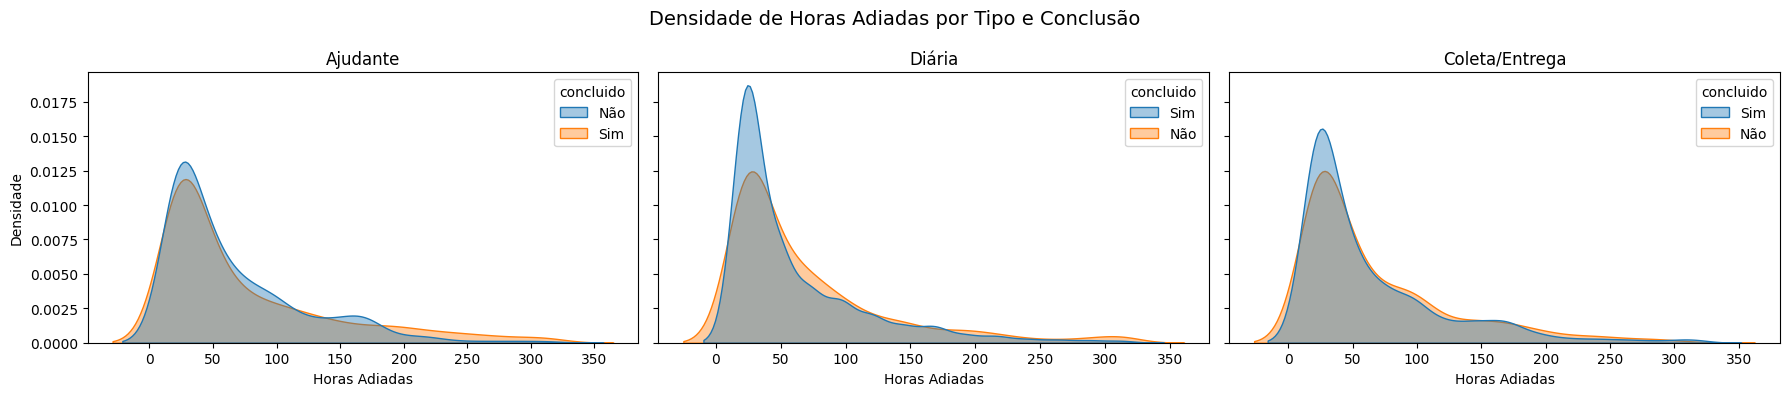

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Carregar os dados
df = df_original_contratos.copy()

# Garantir que horas_adiadas_total é numérico e remover inválidos
df['horas_adiadas_total'] = pd.to_numeric(df['horas_adiadas_total'], errors='coerce')
df = df[df['horas_adiadas_total'].notna()]

# 1. Proporção de concluído por tipo
contagem = df.groupby(['tipo', 'concluido'])['freight_id'].count().unstack(fill_value=0)
contagem['Total'] = contagem.sum(axis=1)
proporcao = (contagem[['Sim', 'Não']].div(contagem['Total'], axis=0) * 100).round(0).astype(int)
proporcao['Total'] = contagem['Total']
proporcao.columns = ['Concluídos (%)', 'Não Concluídos(%)', 'Total Contratos Analisados']
print("Distribuição da quantidade de contratos concluídos:")
print(proporcao)



# 2. KDE por tipo
tipos = df['tipo'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(tipos), figsize=(6 * len(tipos), 4), sharey=True)

for ax, tipo in zip(axes, tipos):
    subset = df[df['tipo'] == tipo]
    sns.kdeplot(data=subset, x='horas_adiadas_total', hue='concluido',
                common_norm=False, fill=True, alpha=0.4, ax=ax)
    ax.set_title(f'{tipo}')
    ax.set_xlabel('Horas Adiadas')
    ax.set_ylabel('Densidade')

fig.suptitle("Densidade de Horas Adiadas por Tipo e Conclusão", fontsize=14)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
from scipy.stats import mannwhitneyu, spearmanr

# Codificar conclusão como binário
df['concluido_bin'] = df['concluido'].map({'Sim': 1, 'Não': 0})

tipos = df['tipo'].unique()
resultados = []

for tipo in tipos:
    grupo = df[df['tipo'] == tipo]
    sim = grupo[grupo['concluido'] == 'Sim']['horas_adiadas_total']
    nao = grupo[grupo['concluido'] == 'Não']['horas_adiadas_total']

    # Teste de Mann-Whitney
    if not sim.empty and not nao.empty:
        stat, pval_mw = mannwhitneyu(sim, nao, alternative='two-sided')
        media_sim = sim.mean()
        media_nao = nao.mean()
        dif_mw = media_sim - media_nao
    else:
        stat, pval_mw = None, None
        media_sim, media_nao = None, None
        dif_mw = None

    # Correlação de Spearman
    if grupo['concluido_bin'].nunique() > 1:
        corr, pval_corr = spearmanr(grupo['concluido_bin'], grupo['horas_adiadas_total'])
    else:
        corr, pval_corr = None, None

    # Interpretação automática
    if pval_mw is not None and pval_mw < 0.05:
        signif = 'Significativo'
        if dif_mw < 0:
            interpretacao = 'Conclui mais com menos horas'
        else:
            interpretacao = 'Conclui mais com mais horas'
    else:
        signif = 'Não significativo'
        interpretacao = 'Sem diferença relevante'

    resultados.append({
        'Tipo': tipo,
        'Média Sim': round(media_sim, 1) if media_sim else None,
        'Média Não': round(media_nao, 1) if media_nao else None,
        'Diferença Médias': round(dif_mw, 1) if dif_mw else None,
        'Significância': signif,
        'Interpretação': interpretacao
    })

# Resultado final
df_resultado_final = pd.DataFrame(resultados)
display(df_resultado_final)




,Tipo,Média Sim,Média Não,Diferença Médias,Significância,Interpretação
0,Ajudante,74.2,65.4,8.8,Não significativo,Sem diferença relevante
1,Diária,60.1,69.1,-9.0,Significativo,Conclui mais com menos horas
2,Coleta/Entrega,63.2,67.5,-4.3,Não significativo,Sem diferença relevante


/tmp/ipykernel_325536/2757168746.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tipo.groupby('faixa_horas')


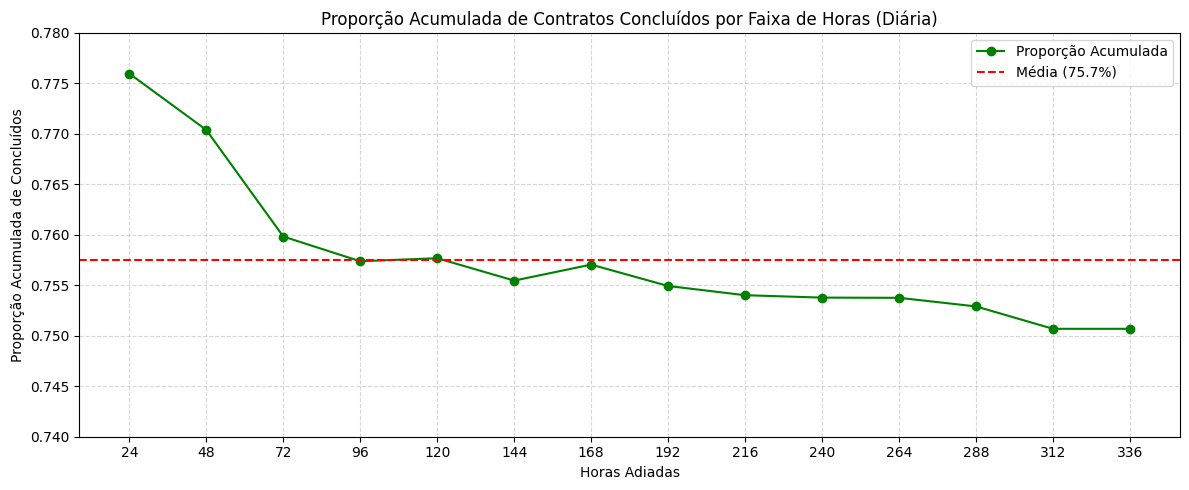

/tmp/ipykernel_325536/2757168746.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tipo.groupby('faixa_horas')


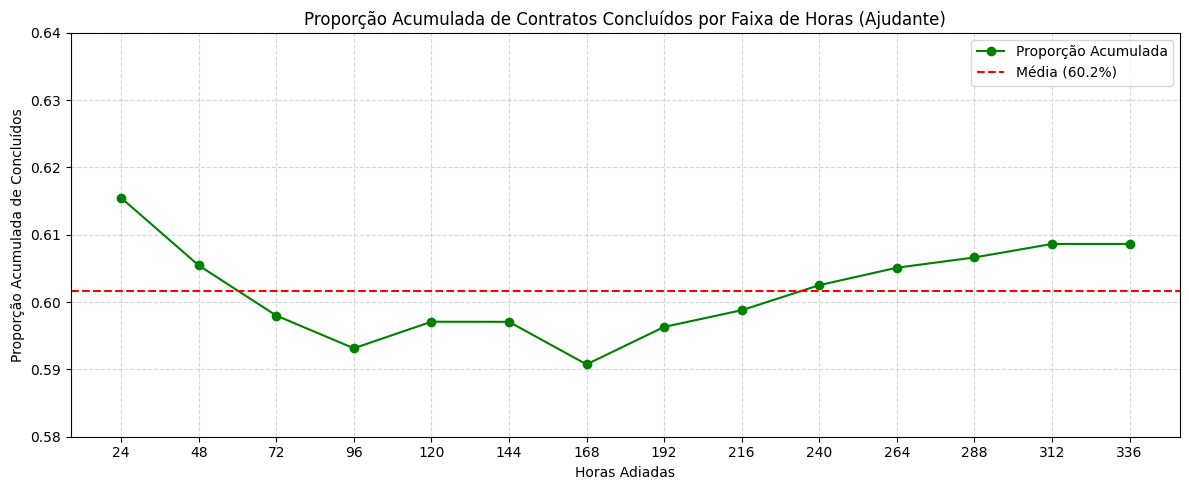

/tmp/ipykernel_325536/2757168746.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tipo.groupby('faixa_horas')


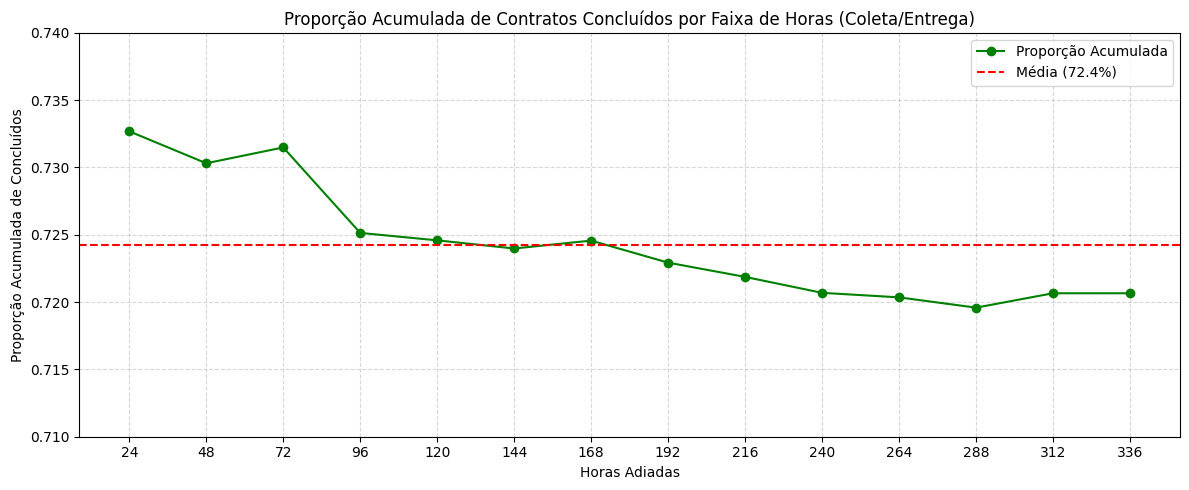

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dicionário com ylim por tipo
ylim_dict = {
    'Diária': (0.74, 0.78),
    'Ajudante': (0.58, 0.64),
    'Coleta/Entrega': (0.71, 0.74)
}

# Tipos a analisar
tipos = ['Diária', 'Ajudante', 'Coleta/Entrega']

for tipo in tipos:
    # Filtrar
    df_tipo = df[df['tipo'] == tipo].copy()
    df_tipo['concluido_bin'] = df_tipo['concluido'].map({'Sim': 1, 'Não': 0})

    # Bins e rótulos corrigidos
    max_horas = int(df_tipo['horas_adiadas_total'].max()) + 24
    bins = list(range(0, max_horas + 1, 24))
    limites_superiores = bins[1:]  # Usado para rotular cada ponto como "até Xh"

    df_tipo['faixa_horas'] = pd.cut(
        df_tipo['horas_adiadas_total'],
        bins=bins,
        right=True,
        include_lowest=True
    )

    # Agrupar
    tabela = (
        df_tipo.groupby('faixa_horas')
        .agg(
            total_contratos=('concluido_bin', 'count'),
            total_concluidos=('concluido_bin', 'sum')
        )
        .reset_index(drop=True)
    )
    tabela['limite_superior'] = limites_superiores
    tabela['acumulado_contratos'] = tabela['total_contratos'].cumsum()
    tabela['acumulado_concluidos'] = tabela['total_concluidos'].cumsum()
    tabela['proporcao_acumulada'] = tabela['acumulado_concluidos'] / tabela['acumulado_contratos']
    media_proporcao = tabela['proporcao_acumulada'].mean()

    # Plotar
    plt.figure(figsize=(12, 5))
    plt.plot(
        tabela['limite_superior'],
        tabela['proporcao_acumulada'],
        marker='o',
        color='green',
        label='Proporção Acumulada'
    )
    plt.axhline(
        y=media_proporcao,
        linestyle='--',
        color='red',
        label=f'Média ({media_proporcao:.1%})'
    )

    # Título e eixos
    plt.title(f"Proporção Acumulada de Contratos Concluídos por Faixa de Horas ({tipo})")
    plt.xlabel("Horas Adiadas")
    plt.ylabel("Proporção Acumulada de Concluídos")
    plt.xticks(tabela['limite_superior'], labels=[f"{x}" for x in tabela['limite_superior']])
    plt.ylim(*ylim_dict[tipo])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ADIAMENTOS

In [11]:
df_original

,ano_mes,tipo,horas_adiadas,concluido,houve_candidatura,houve_selecionado
0,2025-03-01,Diária,24.0,Não,Sim,Sim
1,2025-03-01,Coleta/Entrega,48.0,Sim,Sim,Não
2,2025-03-01,Ajudante,24.0,Não,Não,Não
3,2025-03-01,Diária,24.0,Sim,Sim,Sim
4,2025-03-01,Diária,48.0,Não,Sim,Sim
...,...,...,...,...,...,...
11539,2025-03-01,Coleta/Entrega,48.0,Sim,Sim,Não
11540,2025-03-01,Diária,72.0,Não,Sim,Não
11541,2025-03-01,Diária,24.0,Sim,Sim,Sim
11542,2025-03-01,Diária,24.0,Sim,Sim,Não


In [21]:
# Garantir colunas como string
df_original['houve_candidatura'] = df_original['houve_candidatura'].astype(str)
df_original['houve_selecionado'] = df_original['houve_selecionado'].astype(str)

# Número de meses únicos para média mensal
num_meses = df_original['ano_mes'].nunique()

# Função auxiliar para contar por tipo e candidatura
def contar_por_grupo(candidatura_status, prefixo):
    df_filtrado = df_original[df_original['houve_candidatura'] == candidatura_status]
    agrupado = df_filtrado.groupby(['tipo', 'houve_selecionado']).size().unstack(fill_value=0)
    total_por_tipo = df_filtrado.groupby('tipo').size()
    agrupado['Total'] = total_por_tipo
    agrupado = (agrupado / num_meses).round().astype(int)  # média mensal como inteiro
    # Renomear colunas com prefixo
    agrupado = agrupado.rename(columns={
        'Sim': f'Selecionado_Sim_{prefixo}',
        'Não': f'Selecionado_Nao_{prefixo}',
        'Total': f'Total_Candidatura_{prefixo}'
    })
    return agrupado

# Gerar tabelas separadas
candidatura_sim = contar_por_grupo('Sim', 'Sim')
candidatura_nao = contar_por_grupo('Não', 'Nao')

# Unir resultados
resultado = pd.concat([candidatura_sim, candidatura_nao], axis=1).fillna(0).astype(int)

# Reorganizar colunas
resultado = resultado[
    ['Total_Candidatura_Sim', 'Selecionado_Sim_Sim', 'Selecionado_Nao_Sim',
     'Total_Candidatura_Nao', 'Selecionado_Sim_Nao', 'Selecionado_Nao_Nao']
]

resultado

houve_selecionado,Total_Candidatura_Sim,Selecionado_Sim_Sim,Selecionado_Nao_Sim,Total_Candidatura_Nao,Selecionado_Sim_Nao,Selecionado_Nao_Nao
tipo,,,,,,
Ajudante,411,189,222,107,0,107
Coleta/Entrega,517,204,312,115,8,108
Diária,1057,496,562,102,13,89


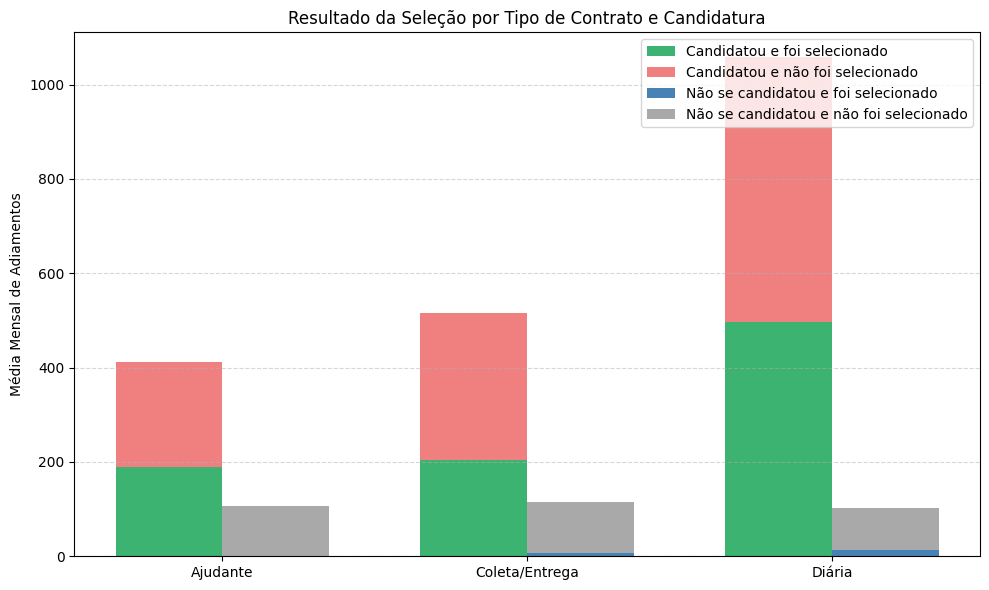

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Usar os dados da tabela que você passou
dados = {
    'tipo': ['Ajudante', 'Coleta/Entrega', 'Diária'],
    'Cand_Sim_Selecionado': [189, 204, 496],
    'Cand_Sim_Nao_Selecionado': [222, 312, 562],
    'Cand_Nao_Selecionado': [0, 8, 13],
    'Cand_Nao_Nao_Selecionado': [107, 108, 89]
}

df_plot = pd.DataFrame(dados).set_index('tipo')

# Plot agrupado
tipos = df_plot.index
x = range(len(tipos))

bar_width = 0.35

plt.figure(figsize=(10, 6))

# Candidatos que se candidataram
plt.bar(
    [i - bar_width / 2 for i in x],
    df_plot['Cand_Sim_Selecionado'],
    width=bar_width,
    label='Candidatou e foi selecionado',
    color='mediumseagreen'
)
plt.bar(
    [i - bar_width / 2 for i in x],
    df_plot['Cand_Sim_Nao_Selecionado'],
    width=bar_width,
    bottom=df_plot['Cand_Sim_Selecionado'],
    label='Candidatou e não foi selecionado',
    color='lightcoral'
)

# Candidatos que NÃO se candidataram
plt.bar(
    [i + bar_width / 2 for i in x],
    df_plot['Cand_Nao_Selecionado'],
    width=bar_width,
    label='Não se candidatou e foi selecionado',
    color='steelblue'
)
plt.bar(
    [i + bar_width / 2 for i in x],
    df_plot['Cand_Nao_Nao_Selecionado'],
    width=bar_width,
    bottom=df_plot['Cand_Nao_Selecionado'],
    label='Não se candidatou e não foi selecionado',
    color='darkgray'
)

# Ajustes visuais
plt.xticks(x, tipos)
plt.ylabel('Média Mensal de Adiamentos')
plt.title('Resultado da Seleção por Tipo de Contrato e Candidatura')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [13]:
# considerando apenas os contratos concluidos
df = df_original[df_original['concluido'] == 'Sim']

# Quantidade de contratos com ou sem candidatura antes da postergação, por tipo
candidatura_por_tipo = df.groupby(['tipo', 'houve_candidatura']).size().reset_index(name='qt_adiamentos')


candidatura_por_tipo

,tipo,houve_candidatura,qt_adiamentos
0,Ajudante,Não,236
1,Ajudante,Sim,1317
2,Coleta/Entrega,Não,376
3,Coleta/Entrega,Sim,1852
4,Diária,Não,298
5,Diária,Sim,3922


In [14]:
# Contar contratos por mês, tipo e se houve candidatura
candidatura_mensal = (
    df.groupby(['ano_mes', 'tipo', 'houve_candidatura'])
    .size()
    .reset_index(name='qt_adiamentos')
)

# Calcular a média mensal por tipo e candidatura (para usar como linha de referência)
media_por_tipo = (
    candidatura_mensal
    .groupby(['tipo', 'houve_candidatura'])['qt_adiamentos']
    .mean()
    .reset_index(name='media_mensal')
)

# Juntar ao dataframe original para plotar a linha média junto
candidatura_mensal = candidatura_mensal.merge(media_por_tipo, on=['tipo', 'houve_candidatura'])
candidatura_mensal

,ano_mes,tipo,houve_candidatura,qt_adiamentos,media_mensal
0,2024-11-01,Ajudante,Não,36,47.2
1,2024-11-01,Ajudante,Sim,274,263.4
2,2024-11-01,Coleta/Entrega,Não,48,75.2
3,2024-11-01,Coleta/Entrega,Sim,392,370.4
4,2024-11-01,Diária,Não,30,59.6
5,2024-11-01,Diária,Sim,801,784.4
6,2024-12-01,Ajudante,Não,54,47.2
7,2024-12-01,Ajudante,Sim,198,263.4
8,2024-12-01,Coleta/Entrega,Não,199,75.2
9,2024-12-01,Coleta/Entrega,Sim,504,370.4


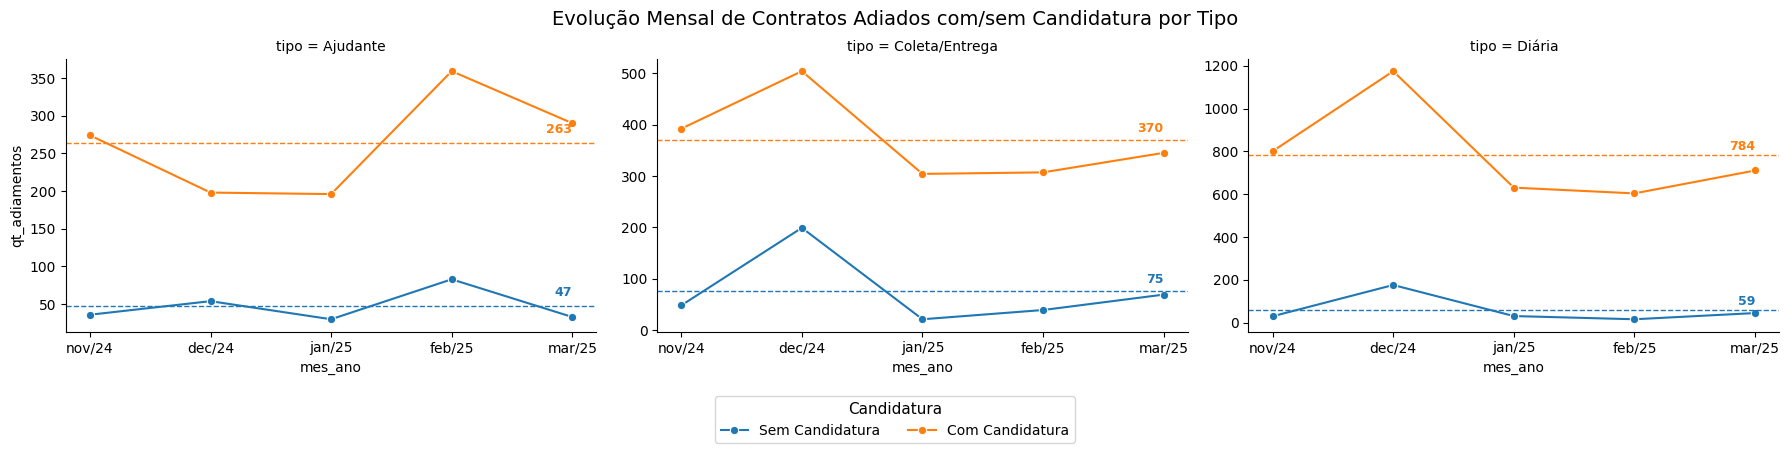

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir que o índice está em datetime e forçar mês/ano como início do mês
candidatura_mensal['ano_mes'] = pd.to_datetime(candidatura_mensal['ano_mes'])
candidatura_mensal.set_index('ano_mes', inplace=True)
candidatura_mensal.index = candidatura_mensal.index.to_period('M').to_timestamp()

# Criar coluna de mês/ano formatado como "nov/24", "dez/24", etc
candidatura_mensal['mes_ano'] = candidatura_mensal.index.strftime('%b/%y').str.lower()

# Gráfico com FacetGrid
g = sns.FacetGrid(candidatura_mensal, col="tipo", hue="houve_candidatura", sharey=False, height=4, aspect=1.5)
g.map(sns.lineplot, "mes_ano", "qt_adiamentos", marker="o")
g.set_xticklabels(rotation=0)

# Obter paleta de cores
palette = dict(zip(g._legend_data.keys(), [h.get_color() for h in g._legend_data.values()]))

# Adicionar linha média + anotação
for ax, (tipo, subdata) in zip(g.axes.flat, candidatura_mensal.groupby('tipo')):
    for candidatura, sub in subdata.groupby('houve_candidatura'):
        media = sub['media_mensal'].iloc[0]
        color = palette[candidatura]
        ax.axhline(y=media, linestyle='--', color=color, linewidth=1)
        ultimo_x = sub['mes_ano'].iloc[-1]
        ax.text(x=ultimo_x, y=media + 10, s=f'{int(media)}', color=color, fontsize=9,
                ha='right', va='bottom', fontweight='bold')

# Título principal
g.fig.suptitle("Evolução Mensal de Contratos Adiados com/sem Candidatura por Tipo", fontsize=14, y=0.95)

# Legenda centralizada abaixo dos gráficos
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(
    handles[:2],
    ['Sem Candidatura', 'Com Candidatura'],
    title='Candidatura',
    loc='lower center',
    ncol=2,
    fontsize=10,
    title_fontsize=11,
    bbox_to_anchor=(0.5, -0.15)
)

# Ajustar layout para acomodar legenda e título
g.fig.subplots_adjust(top=0.88, bottom=0.2)
plt.tight_layout()
plt.show()



In [16]:
# Contar contratos por mês, tipo e se houve candidatura
selecionado_mensal = (
    df.groupby(['ano_mes', 'tipo', 'houve_selecionado'])
    .size()
    .reset_index(name='qt_adiamentos')
)

# Calcular a média mensal por tipo e candidatura (para usar como linha de referência)
media_por_tipo = (
    selecionado_mensal
    .groupby(['tipo', 'houve_selecionado'])['qt_adiamentos']
    .mean()
    .reset_index(name='media_mensal')
)

# Juntar ao dataframe original para plotar a linha média junto
selecionado_mensal = selecionado_mensal.merge(media_por_tipo, on=['tipo', 'houve_selecionado'])
selecionado_mensal


,ano_mes,tipo,houve_selecionado,qt_adiamentos,media_mensal
0,2024-11-01,Ajudante,Não,192,175.2
1,2024-11-01,Ajudante,Sim,118,135.4
2,2024-11-01,Coleta/Entrega,Não,265,280.6
3,2024-11-01,Coleta/Entrega,Sim,175,165.0
4,2024-11-01,Diária,Não,438,451.8
5,2024-11-01,Diária,Sim,393,392.2
6,2024-12-01,Ajudante,Não,140,175.2
7,2024-12-01,Ajudante,Sim,112,135.4
8,2024-12-01,Coleta/Entrega,Não,509,280.6
9,2024-12-01,Coleta/Entrega,Sim,194,165.0


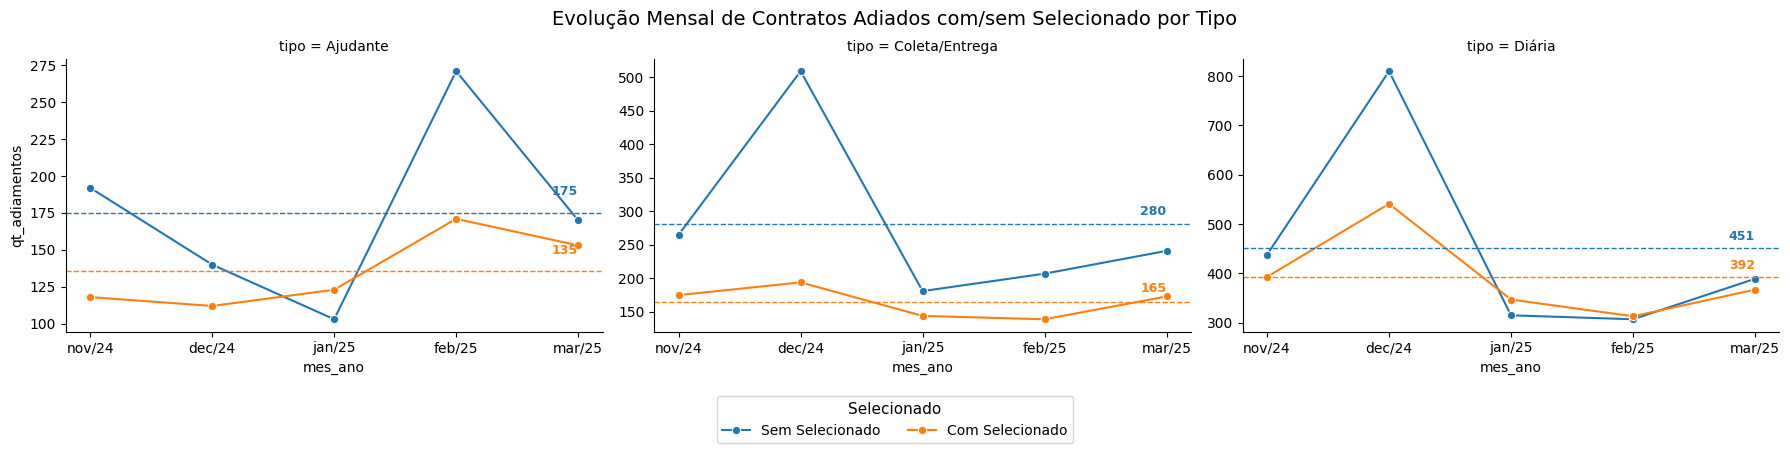

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir que o índice está em datetime e forçar mês/ano como início do mês
selecionado_mensal['ano_mes'] = pd.to_datetime(selecionado_mensal['ano_mes'])
selecionado_mensal.set_index('ano_mes', inplace=True)
selecionado_mensal.index = selecionado_mensal.index.to_period('M').to_timestamp()

# Criar coluna de mês/ano formatado como "nov/24", "dez/24", etc
selecionado_mensal['mes_ano'] = selecionado_mensal.index.strftime('%b/%y').str.lower()

# Gráfico com FacetGrid
g = sns.FacetGrid(selecionado_mensal, col="tipo", hue="houve_selecionado", sharey=False, height=4, aspect=1.5)
g.map(sns.lineplot, "mes_ano", "qt_adiamentos", marker="o")
g.set_xticklabels(rotation=0)

# Obter paleta de cores
palette = dict(zip(g._legend_data.keys(), [h.get_color() for h in g._legend_data.values()]))

# Adicionar linha média + anotação
for ax, (tipo, subdata) in zip(g.axes.flat, selecionado_mensal.groupby('tipo')):
    for candidatura, sub in subdata.groupby('houve_selecionado'):
        media = sub['media_mensal'].iloc[0]
        color = palette[candidatura]
        ax.axhline(y=media, linestyle='--', color=color, linewidth=1)
        ultimo_x = sub['mes_ano'].iloc[-1]
        ax.text(x=ultimo_x, y=media + 10, s=f'{int(media)}', color=color, fontsize=9,
                ha='right', va='bottom', fontweight='bold')

# Título principal
g.fig.suptitle("Evolução Mensal de Contratos Adiados com/sem Selecionado por Tipo", fontsize=14, y=0.95)

# Legenda centralizada abaixo dos gráficos
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.legend(
    handles[:2],
    ['Sem Selecionado', 'Com Selecionado'],
    title='Selecionado',
    loc='lower center',
    ncol=2,
    fontsize=10,
    title_fontsize=11,
    bbox_to_anchor=(0.5, -0.15)
)

# Ajustar layout para acomodar legenda e título
g.fig.subplots_adjust(top=0.88, bottom=0.2)
plt.tight_layout()
plt.show()

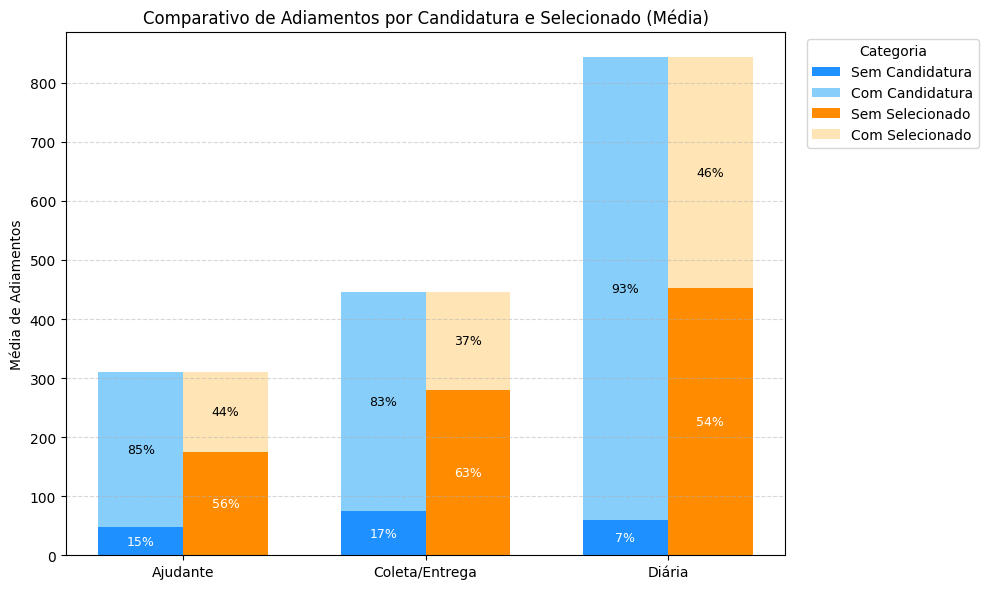

In [12]:
import matplotlib.pyplot as plt
import numpy as np

dados_consolidados = {
    'tipo': ['Ajudante', 'Coleta/Entrega', 'Diária'],
    'Com Candidatura': [263.4, 370.4, 784.4],
    'Sem Candidatura': [47.2, 75.2, 59.6],
    'Com Selecionado': [135.4, 165.0, 392.2],
    'Sem Selecionado': [175.2, 280.6, 451.8]
}

df_medianas = pd.DataFrame(dados_consolidados)
df_medianas
# Usar os dados atualizados das médias consolidadas
df = df_medianas.copy()
x = np.arange(len(df['tipo']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Barras empilhadas - Candidatura
p1 = ax.bar(x - width/2, df['Sem Candidatura'], width, label='Sem Candidatura', color='dodgerblue')
p2 = ax.bar(x - width/2, df['Com Candidatura'], width, bottom=df['Sem Candidatura'], label='Com Candidatura', color='lightskyblue')

# Barras empilhadas - Selecionado
p3 = ax.bar(x + width/2, df['Sem Selecionado'], width, label='Sem Selecionado', color='darkorange')
p4 = ax.bar(x + width/2, df['Com Selecionado'], width, bottom=df['Sem Selecionado'], label='Com Selecionado', color='moccasin')

# Adiciona percentual dentro de cada pedaço da barra
for i in range(len(df)):
    # Candidatura
    total_cand = df.loc[i, 'Sem Candidatura'] + df.loc[i, 'Com Candidatura']
    pct_sem_cand = df.loc[i, 'Sem Candidatura'] / total_cand * 100
    pct_com_cand = df.loc[i, 'Com Candidatura'] / total_cand * 100
    ax.text(x[i] - width/2, df.loc[i, 'Sem Candidatura']/2, f'{pct_sem_cand:.0f}%', ha='center', va='center', color='white', fontsize=9)
    ax.text(x[i] - width/2, df.loc[i, 'Sem Candidatura'] + df.loc[i, 'Com Candidatura']/2, f'{pct_com_cand:.0f}%', ha='center', va='center', color='black', fontsize=9)

    # Selecionado
    total_sel = df.loc[i, 'Sem Selecionado'] + df.loc[i, 'Com Selecionado']
    pct_sem_sel = df.loc[i, 'Sem Selecionado'] / total_sel * 100
    pct_com_sel = df.loc[i, 'Com Selecionado'] / total_sel * 100
    ax.text(x[i] + width/2, df.loc[i, 'Sem Selecionado']/2, f'{pct_sem_sel:.0f}%', ha='center', va='center', color='white', fontsize=9)
    ax.text(x[i] + width/2, df.loc[i, 'Sem Selecionado'] + df.loc[i, 'Com Selecionado']/2, f'{pct_com_sel:.0f}%', ha='center', va='center', color='black', fontsize=9)

# Eixos e legendas
ax.set_xticks(x)
ax.set_xticklabels(df['tipo'])
ax.set_ylabel("Média de Adiamentos")
ax.set_title("Comparativo de Adiamentos por Candidatura e Selecionado (Média)")
ax.legend(title='Categoria', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
